# Overview

This notebook contains an exploration of data supplied by Stroud Town Council's Vehicle Activiated Road Signs (VAS) in order to address a number of key questions.

In [117]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the underlying code for this analysis"></form>''')

In [121]:
# First we load and clean the data
import glob
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

df_raw = pd.read_csv('../data.csv', low_memory=False)
df = df_raw[df_raw.date != 'Date']
del df['direction']

# Location names need cleaning up
def clean_location_name(name):
    name = name.split()[:2]
    name = ' '.join(name).replace(' Speed data', '')
    name = name.replace('London Road London Road', 'London Road')
    name = name.replace('Parliament Street', 'Parliament St')
    name = name.replace('Down Parliamnet', 'Down Parliament')
    return name

df['location_clean'] = df.location.apply(clean_location_name)

df['status'] = df['status'].replace('off_new.csv','off')
df['status'] = df['status'].replace('on.csv','on')
df['status'] = df['status'].replace('off.csv','off')

df = df[df.status!='group']

df['speed_numeric'] = pd.to_numeric(df.speed)
df['date_clean'] = pd.to_datetime(df.date, format='%d/%m/%Y %H:%M:%S')
df['day'] = df.date_clean.dt.day
df['hour'] = df.date_clean.dt.hour
df['dayofweek'] = df.date_clean.dt.dayofweek
df['hourofweek'] = (df.dayofweek + 1) * (df.hour + 1)

# Note - these are approximate locations only - and need to be updated
location_map = {
        "London Road":[51.741758,-2.212442],
        "Down Parliament":[51.745431,-2.212112],
        "Up Bisley":[51.744811,-2.206233],
        "Slad Road":[51.749437,-2.207603],
        "Stratford Road":[51.748298,-2.223043],
        "Up Parliament":[51.745431,-2.212112],
        "Down Bisley":[51.744811,-2.206233]
    }

ldf = pd.DataFrame(location_map).transpose()
ldf.columns=['lat','lng']
ldf['location_clean'] = ldf.index

df = pd.merge(df,ldf,on='location_clean')

df['month_year'] = df.date_clean.apply(lambda x: x.strftime('%Y-%m')) 


# Questions for the data

* Are there significant differences in the data when the cameras are on or off.

* How long does the effect last?

Whether the longer the period since the camera was on, the more speeding creeps up, or whether people start to switch off and  speed when the camera has been on for a few weeks.

* Are there particular times of day when speeding is worse? 

## Describing the data we have

This analysis is based on data from October 2018 to early August 2019. It includes observations from when VAS displays were turned on (showing speed to drivers) and off (recording, but not displaying speeds). 

The two charts below show the number of measurements available from the 'off' and 'on' states respectively from the different sign locations. 

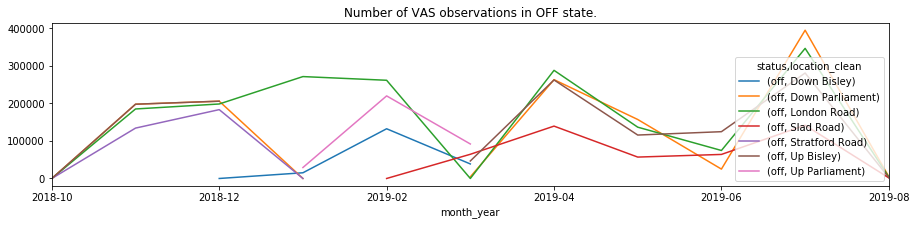

In [171]:
# How does the "off" data look.
location_by_month_off = df.groupby([df.month_year, df.location_clean, df.status]).count().date_clean
lbm = location_by_month_off.unstack()
lbm[['off']].fillna(0).unstack(1).plot(kind="line", figsize=[15,3], title='Number of VAS observations in OFF state.')

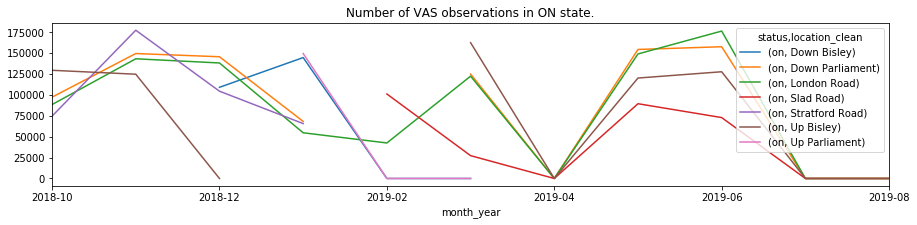

In [175]:
lbm[['on']].fillna(0).unstack(1).plot(kind="line", figsize=[15,3], title='Number of VAS observations in ON state.')

### Interpreting the data

Each VAS record multiple observations for each sequence of vehicles that pass. This means there is no one-to-one correlation between speed observations, and **the number of speeding cars**. For example, a series of observations of 30 MPH within a 30 seconds may be one vehicle, or it may be a number of vehicles. 

Because, depending on the speed of a car, the gaps between cars, and how the sign is triggered, the number of observations in the dataset vary, averages need to be interpreted carefully, and treated as a rough indication of the speeds a pedestrian may experience on the road at the particular time. Because we cannot distinguish individual vehicles in the data, we can only get a mean average, not a mode or median speed. 

## Speed distribution

The plot below shows the overall distribution of speed observations, indicating the majority of obsvations are above 20 MPH. 

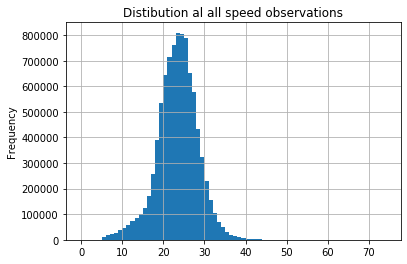

In [192]:
# Eyeball the overall speed distribution.
df.speed_numeric.plot(kind='hist', bins=range(0, 75),title='Distibution of all speed observations', grid=True)


## What difference do the signs make?

We can look at what happens to the average (mean) of speed observations when the signs are on. The analysis below shows that the signs reduce the mean speed by approximately 1 MPH.

Whilst a low average reduction, this indicates they are having an effect. This is visualised in the chart below which shows the number of speed observations when the signs are on or off.


In [46]:
df.groupby('status').mean()['speed_numeric']

status
off    23.339455
on     22.334460
Name: speed_numeric, dtype: float64

status
off    AxesSubplot(0.125,0.125;0.775x0.755)
on     AxesSubplot(0.125,0.125;0.775x0.755)
Name: speed_numeric, dtype: object

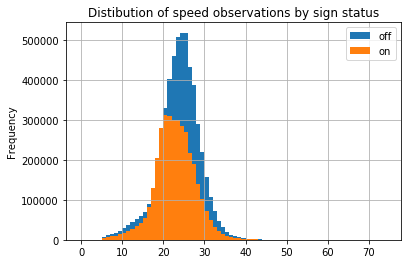

In [196]:
df.groupby(['status']).speed_numeric.plot(kind='hist', bins=range(0, 75),title='Distibution of speed observations by sign status', grid=True, legend=True)

## Speeding by time of day / day of week

We can look at the mean speed in each location by day of the week and hour of the day. The following chart indicates higher speeding on weekends, particularly Sunday (perhaps due to the lower number of cars on the road?)

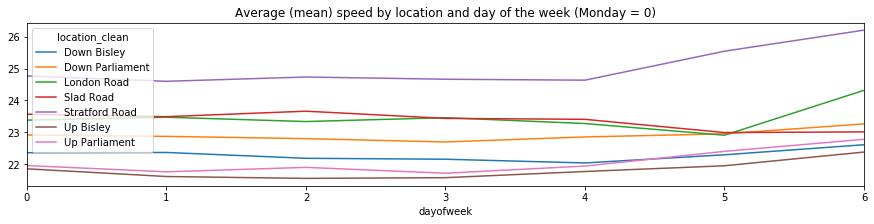

In [197]:
# High-level mean speed by day of week (not very interesting)
df.groupby(['dayofweek','location_clean']).mean()['speed_numeric'].unstack().plot(kind="line", figsize=[15,3], title="Average (mean) speed by location and day of the week (Monday = 0)")

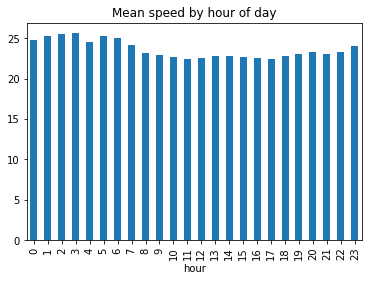

In [42]:
# High-level mean speed by hour of day
speed_by_hour_of_day = df.groupby('hour').mean()['speed_numeric']
speed_by_hour_of_day.plot(kind='bar', title ="Mean speed by hour of day")

## Highest and lowest speeds recorded

We can look at which locations record a high number of speeding obsevations over 20 MPH. The following table shows obsevations in 10 MPH buckets, indicating the greater number of obsevered speeding incidents are on London Road. 

Note that this may be due to the fact the sign has been recording most constantly here. Further work is needed to look at percentage of observations at high speeds, to check for key hot-spots. 

The data suggests a major issue with people driving over 40 MPH in the 20 MPH zones, but a low incidence of much higher speeds.

In [220]:
df['over30'] = (df.speed_numeric>30).astype(int)
df['over40'] = (df.speed_numeric>40).astype(int)
df['over50'] = (df.speed_numeric>50).astype(int)
df['over60'] = (df.speed_numeric>60).astype(int)

In [218]:
# All speeds over 60mph, grouped by location.
df.groupby('location_clean')[['over30','over40','over50','over60']].sum()

,over30,over40,over50,over60
location_clean,,,,
Down Bisley,15680,357,18,4
Down Parliament,109497,2028,125,13
London Road,145319,5685,521,47
Slad Road,62885,899,29,1
Stratford Road,52926,711,36,0
Up Bisley,75191,1600,110,9
Up Parliament,10707,200,6,0


We can also look at the time of day when speeds > 30 MPH are recorded in each location. 

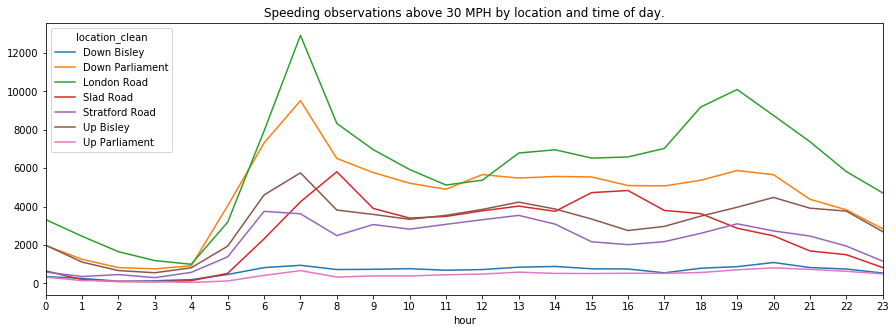

In [260]:
ls = df.groupby(['location_clean','hour'])[['over30','over40','over50','over60']].sum().unstack(1)
ls['over30'].transpose().plot(figsize=[15,5],x_compat=True, xticks=range(0,24),title="Speeding observations above 30 MPH by location and time of day.")

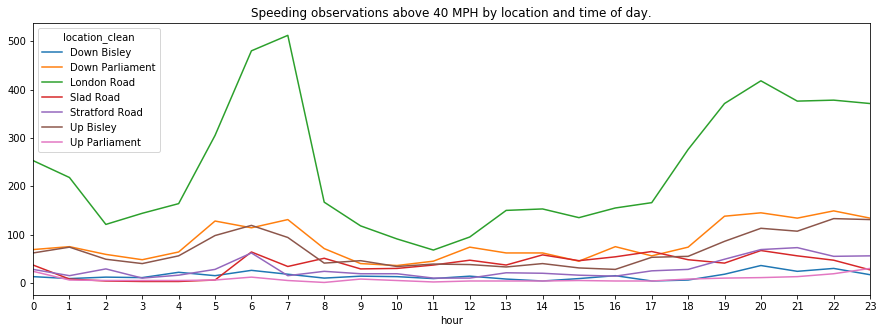

In [261]:
ls['over40'].transpose().plot(figsize=[15,5],x_compat=True, xticks=range(0,24),title="Speeding observations above 40 MPH by location and time of day.")

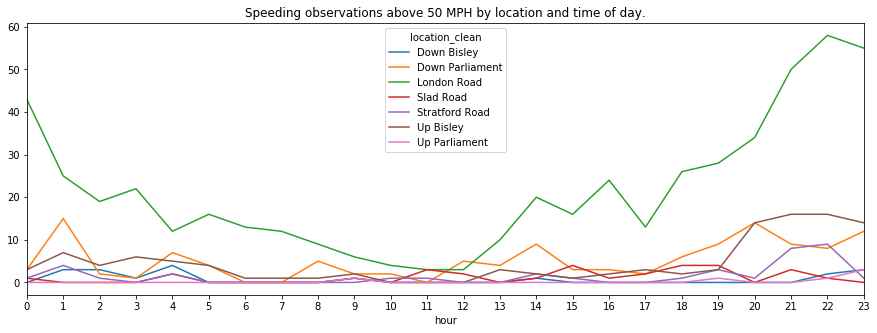

In [262]:
ls['over50'].transpose().plot(figsize=[15,5],x_compat=True, xticks=range(0,24),title="Speeding observations above 50 MPH by location and time of day.")

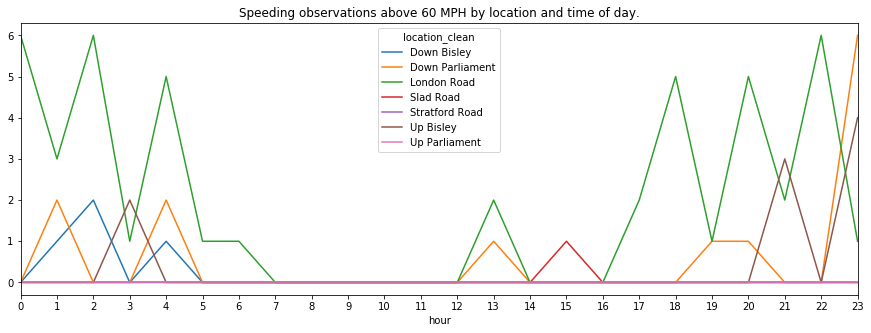

In [263]:
ls['over60'].transpose().plot(figsize=[15,5],x_compat=True, xticks=range(0,24),title="Speeding observations above 60 MPH by location and time of day.")

## Residual effect

We want to also explore how long the impact of the signs lasts. To do this, we want to calculate the time since the last state change of the sign. 

We can then plot the mean speed depending on how many days it is since the sign was on or off.

In [ ]:
df['date'] = df.date_clean.apply(lambda x: x.strftime('%Y-%m-%d'))

In [291]:
re = df.groupby(['location_clean','status','date']).speed_numeric.mean().reset_index()

old_state = ""
days_since = 0
new_data = []

for index, row in re.iterrows():
    this_state = row['location_clean'] + row['status']
    if(this_state == old_state):
        days_since = days_since + 1
    else:
        days_since = 0
    new_data.append(days_since)
    old_state = this_state

re['days_since'] = new_data

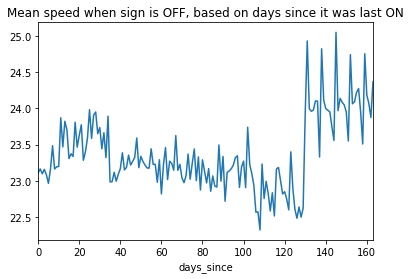

In [297]:
re[re['status']=='off'].groupby('days_since').speed_numeric.mean().plot(title='Mean speed when sign is OFF, based on days since it was last ON')

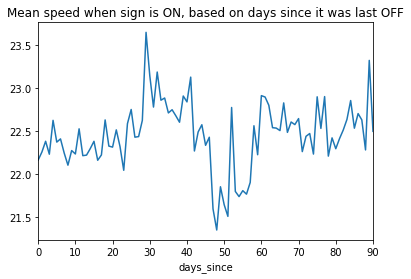

In [299]:
re[re['status']=='on'].groupby('days_since').speed_numeric.mean().plot(title='Mean speed when sign is ON, based on days since it was last OFF')

More work is needed to get this data into a shape where it can tell a clear story. The story is slightly clearer if we look at the first 30 days after any switch (on the basis that longer periods may be outliers from single signs).

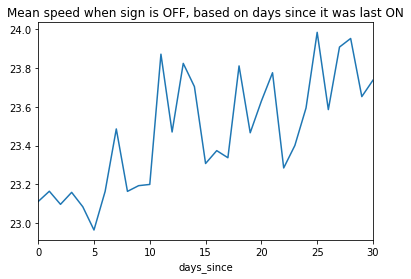

In [301]:
re[(re['status']=='off') & (re['days_since'] < 31)].groupby('days_since').speed_numeric.mean().plot(title='Mean speed when sign is OFF, based on days since it was last ON')

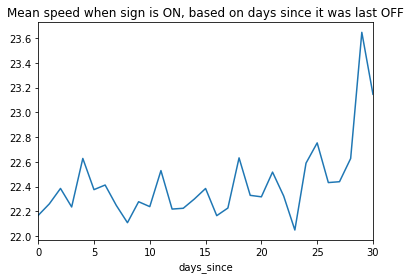

In [302]:
re[(re['status']=='on') & (re['days_since'] < 31)].groupby('days_since').speed_numeric.mean().plot(title='Mean speed when sign is ON, based on days since it was last OFF')

In the 30 day window we do appear to see speeds going up 

## Location analysis

This adds lat,lng to be able to map the data

In [85]:
location_map = {
        "London Road":[51.741758,-2.212442],
        "Down Parliament":[51.745431,-2.212112],
        "Up Bisley":[51.744811,-2.206233],
        "Slad Road":[51.749437,-2.207603],
        "Stratford Road":[51.748298,-2.223043],
        "Up Parliament":[51.745431,-2.212112],
        "Down Bisley":[51.744811,-2.206233]
    }

ldf = pd.DataFrame(location_map).transpose()
ldf.columns=['lat','lng']
ldf['location_clean'] = ldf.index

merged = pd.merge(df,ldf,on='location_clean')

## Format data for visualisation with Flourish

* Convert to show speeds > 20 MPH
* Add green, amber, red codes to show how bad the speeding is

In [106]:
merged['speeding_amount'] = merged.speed.apply(lambda x: max(int(x) - 20,0))

def flag(speed):
    if(speed < 5):
        return 'green'
    elif(speed < 10):
        return 'amber'
    elif(speed < 20):
        return 'red'
    else:
        return 'black'

merged['flag'] = merged.speeding_amount.apply(flag)

In [111]:
merged[((merged['month_year']=='2019-06') & (merged['day']==1))][['date_clean','speeding_amount','flag','lat','lng']].to_csv('../viz.csv', date_format='%Y-%m-%dT%H:%M:%S.000Z')